# Estudo da rede neural MLP como classificadora do dataset KMNIST

## Bibliotecas

In [1]:
import torch

In [2]:
#  Verificando a versão do PyTorch e se está usando GPU
print('Versão PyTorch: ', torch.__version__)
print('Usando GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

Versão PyTorch:  1.9.0+cu111
Usando GPU:  True
GPU:  NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## Fixando os parâmetros para carregar as imagens

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch import optim

In [4]:
# Transform
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Batch size
batch_size = 120

## Leitura dos dados

In [5]:
# Conjunto de treinamento
trainset = dsets.KMNIST(root='~/data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [6]:
# Conjunto de teste
testset = dsets.KMNIST(root='~/data', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

In [7]:
print(f"> {len(trainset)} amostras de Treino e {len(testset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


## Plotando algumas imagens

In [8]:
import matplotlib.pyplot as plt

In [9]:
labels_dict = {
    0: u"\u304A",
    1: u"\u304D",
    2: u"\u3059",
    3: u"\u3064",
    4: u"\u306A",
    5: u"\u306F",
    6: u"\u307E",
    7: u"\u3084",
    8: u"\u308C",
    9: u"\u3093"
}

In [10]:
print(labels_dict)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'}


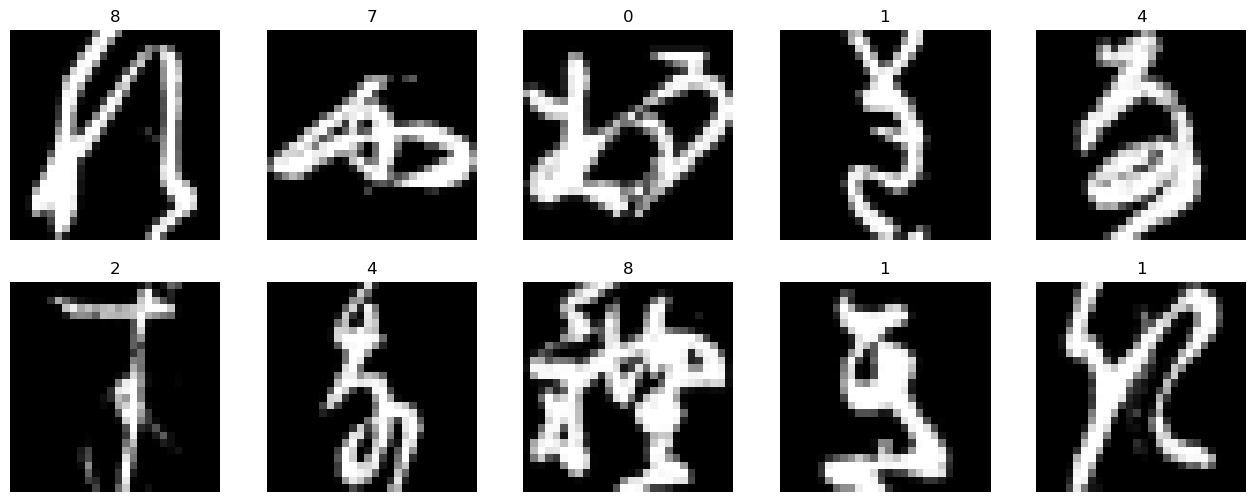

In [11]:
rows, columns = 2, 5

fig, axs = plt.subplots(rows, columns, figsize=(16,6))
for i in range(rows):
    for j in range(columns):
        k = 5*i + j
        axs[i,j].imshow(trainset[k][0].reshape(28,28), cmap=plt.get_cmap("gray"))
        axs[i,j].set_title(trainset[k][1])
        axs[i,j].axis("off")
        axs[i,j].set_aspect("equal")

plt.show()

## Criando a rede

In [12]:
import torch.nn.functional as F
from torch import nn

In [13]:
class ClassifierDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,196)
        self.fc2 = nn.Linear(196,196)
        self.fc3 = nn.Linear(196,196)
        self.fc4 = nn.Linear(196,49)
        self.fc5 = nn.Linear(49,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

## Fixando os hiperparâmetros

In [14]:
model = ClassifierDropout()

# Learning rate
learning_rate = 0.01
# Optimizer
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# Criterion
criterion = torch.nn.CrossEntropyLoss()
# Epoch
epochs = 50

## Treinando a rede

In [15]:
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for image, label in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(image)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for image, label in testloader:         
                
                log_ps = model.forward(image)
                prob = torch.exp(log_ps)
                
                test_loss+= criterion(log_ps, label)
                k_prob, k_class = prob.topk(1, dim=1)
                equals = k_class == label.view(*k_class.shape)
                
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/50..  Training Loss: 2.296..  Test Loss: 2.283..  Test Accuracy: 0.214
Epoch: 2/50..  Training Loss: 2.162..  Test Loss: 2.049..  Test Accuracy: 0.266
Epoch: 3/50..  Training Loss: 1.709..  Test Loss: 1.613..  Test Accuracy: 0.475
Epoch: 4/50..  Training Loss: 1.200..  Test Loss: 1.327..  Test Accuracy: 0.581
Epoch: 5/50..  Training Loss: 0.954..  Test Loss: 1.172..  Test Accuracy: 0.631
Epoch: 6/50..  Training Loss: 0.804..  Test Loss: 1.037..  Test Accuracy: 0.669
Epoch: 7/50..  Training Loss: 0.704..  Test Loss: 0.936..  Test Accuracy: 0.705
Epoch: 8/50..  Training Loss: 0.630..  Test Loss: 0.884..  Test Accuracy: 0.721
Epoch: 9/50..  Training Loss: 0.568..  Test Loss: 0.818..  Test Accuracy: 0.744
Epoch: 10/50..  Training Loss: 0.525..  Test Loss: 0.769..  Test Accuracy: 0.760
Epoch: 11/50..  Training Loss: 0.480..  Test Loss: 0.728..  Test Accuracy: 0.775
Epoch: 12/50..  Training Loss: 0.448..  Test Loss: 0.671..  Test Accuracy: 0.794
Epoch: 13/50..  Training Loss: 0.418.

---

## Avaliando a rede

### Gráfico de convergência

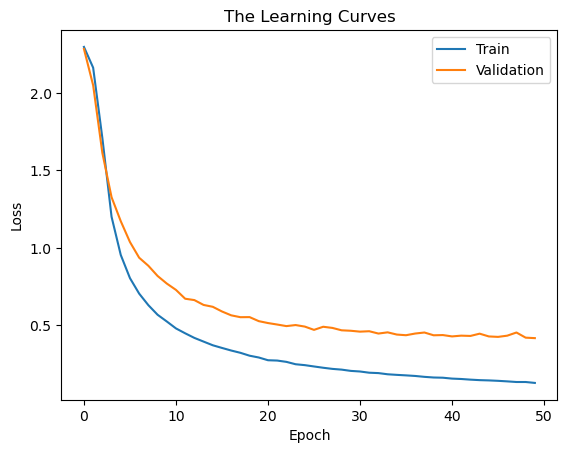

In [16]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()

plt.title('The Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Amostra da probabilidade

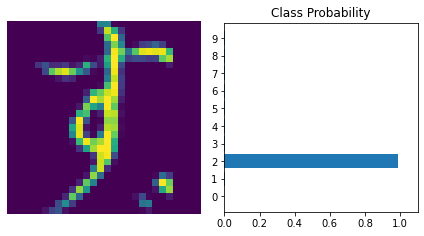

In [17]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade.
# Por isso precisamos fazer o exponencial para termos as probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

### Acurácia

In [18]:
import pandas as pd
from torch.autograd import Variable

In [19]:
predicted = []
expected = []

for image, label in testset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [20]:
results = pd.DataFrame({'predicted': predicted, 'expected': expected})
results

,predicted,expected
0,5,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,4,4
9996,0,0
9997,9,9
9998,4,4


In [21]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.8534


### Matriz de confusão

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

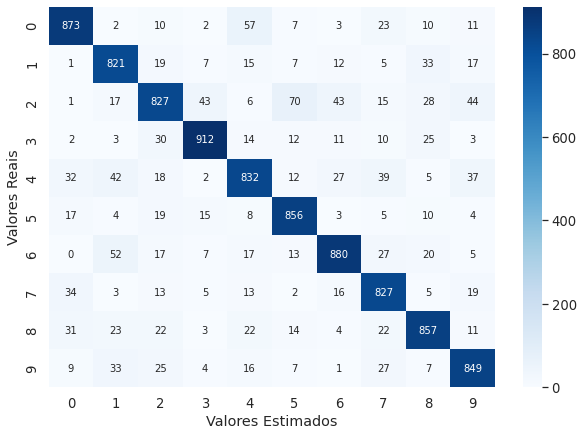

In [23]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valores Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

In [24]:
Pára!!!

SyntaxError: invalid syntax (<ipython-input-24-905716ceefeb>, line 1)

---

# Teste da rede sem `dropout`

## Criando a rede

In [25]:
import torch.nn.functional as F
from torch import nn

In [26]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,196)
        self.fc2 = nn.Linear(196,196)
        self.fc3 = nn.Linear(196,196)
        self.fc4 = nn.Linear(196,49)
        self.fc5 = nn.Linear(49,10)
        
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

## Fixando os hiperparâmetros

In [27]:
model = Classifier()

# Learning rate
learning_rate = 0.01
# Optimizer
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# Criterion
criterion = torch.nn.CrossEntropyLoss()
# Epoch
epochs = 50

## Treinando a rede

In [28]:
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # else pode ser usado em laços tipo for no python, e só será executado se não cair em nenhum break
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # passo de validação
            for images, labels in testloader:
                log_ps = model(images)
                ps = torch.exp(log_ps)
                
                test_loss += criterion(log_ps, labels)  
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/50..  Training Loss: 2.286..  Test Loss: 2.262..  Test Accuracy: 0.184
Epoch: 2/50..  Training Loss: 1.968..  Test Loss: 1.877..  Test Accuracy: 0.360
Epoch: 3/50..  Training Loss: 1.205..  Test Loss: 1.387..  Test Accuracy: 0.554
Epoch: 4/50..  Training Loss: 0.847..  Test Loss: 1.243..  Test Accuracy: 0.603
Epoch: 5/50..  Training Loss: 0.708..  Test Loss: 1.115..  Test Accuracy: 0.641
Epoch: 6/50..  Training Loss: 0.600..  Test Loss: 0.978..  Test Accuracy: 0.682
Epoch: 7/50..  Training Loss: 0.520..  Test Loss: 0.885..  Test Accuracy: 0.711
Epoch: 8/50..  Training Loss: 0.459..  Test Loss: 0.830..  Test Accuracy: 0.731
Epoch: 9/50..  Training Loss: 0.408..  Test Loss: 0.766..  Test Accuracy: 0.753
Epoch: 10/50..  Training Loss: 0.368..  Test Loss: 0.718..  Test Accuracy: 0.774
Epoch: 11/50..  Training Loss: 0.336..  Test Loss: 0.697..  Test Accuracy: 0.783
Epoch: 12/50..  Training Loss: 0.306..  Test Loss: 0.655..  Test Accuracy: 0.800
Epoch: 13/50..  Training Loss: 0.284.

---

## Avaliando a rede

### Gráfico de convergência

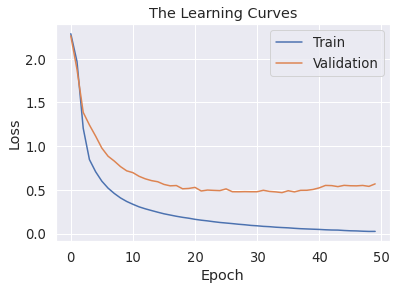

In [29]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()

plt.title('The Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Amostra da probabilidade

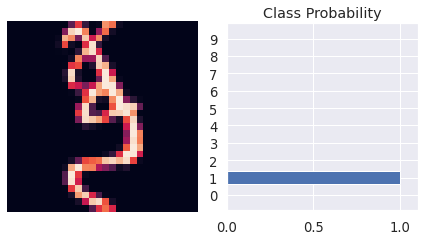

In [30]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade.
# Por isso precisamos fazer o exponencial para termos as probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

### Acurácia

In [31]:
import pandas as pd
from torch.autograd import Variable

In [32]:
predicted = []
expected = []

for image, label in testset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [33]:
results = pd.DataFrame({'predicted': predicted, 'expected': expected})
results

,predicted,expected
0,2,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,4,4
9996,0,0
9997,9,9
9998,4,4


In [34]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.8808


### Matriz de confusão

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

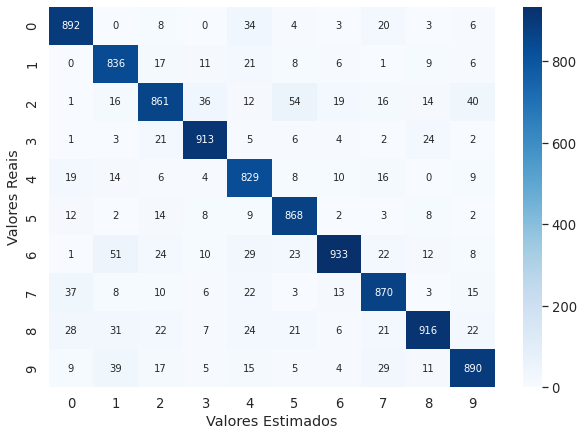

In [36]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valores Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()